In [32]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [33]:
dataset = pd.read_csv('Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
dataset = dataset.drop([0, 1, 2, 3, 504], axis=1)
#dataset.columns = list(range(500))
dataset.head()


,4,5,6,7,8,9,10,11,12,13,...,494,495,496,497,498,499,500,501,502,503
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,...,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,...,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,...,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,...,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,...,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825


In [34]:
def extract_signal_3sigma(signal):
    noise_region = signal[:50]
    baseline = np.mean(noise_region)
    noise_std = np.std(noise_region)

    signal_threshold = baseline + 3 * noise_std
    max_idx = np.argmax(signal)

    end_idx = len(signal) - 1
    for i in range(max_idx, len(signal)):
        if signal[i] <= baseline + 3 * noise_std:
            end_idx = i
            break

    extracted = signal[max_idx:end_idx + 1] - baseline

    return np.array(extracted), max_idx, end_idx, baseline, noise_std

In [35]:
def calculate_tau(signal):

    max_val = np.max(signal)
    max_idx = np.argmax(signal)

    threshold_val = max_val / np.e

    end_idx = len(signal) - 1
    for i in range(max_idx, len(signal)):
        if signal[i] <= threshold_val:
            end_idx = i
            break

    tau = end_idx - max_idx
    return tau

In [36]:
def calculate_psd(signal, short_samples=20):
    total_area = np.sum(signal)
    short_area = np.sum(signal[:short_samples])
    tail_area = total_area - short_area

    psd = tail_area / total_area

    return psd

In [37]:
all_features = []
for i in range(len(dataset)):
    inverted_signal = 2**14 - dataset.iloc[i].values
    final_signal = inverted_signal - 1560
    extracted, max_idx, end_idx, baseline, noise_std = extract_signal_3sigma(final_signal)

    features = {}
    features['amplitude'] = np.max(extracted)
    features['area'] = np.sum(extracted)
    features['tau'] = calculate_tau(extracted)
    features['psd'] = calculate_psd(extracted, 20)
    all_features.append(features)

In [38]:
features_df = pd.DataFrame(all_features)
print(f"Обработано сигналов: {len(features_df)}")

Обработано сигналов: 23479


In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

In [40]:
dbscan = DBSCAN(eps=0.8, min_samples=10)

labels = dbscan.fit_predict(X_scaled)
features_df['cluster_all'] = labels

In [41]:
unique, counts = np.unique(labels[labels != -1], return_counts=True)
top_two = unique[np.argsort(counts)[-2:]]
centers = []

for lbl in top_two:
    centers.append(X_scaled[labels==lbl].mean(axis=0))

centers = np.array(centers)
other_clusters=~np.isin(labels,top_two)

nn = NearestNeighbors(n_neighbors=1).fit(centers)
distances, nearest = nn.kneighbors(X_scaled[other_clusters])
labels[other_clusters] = nearest.flatten()

print(np.unique(labels))
features_df['cluster'] = labels

[0 1]


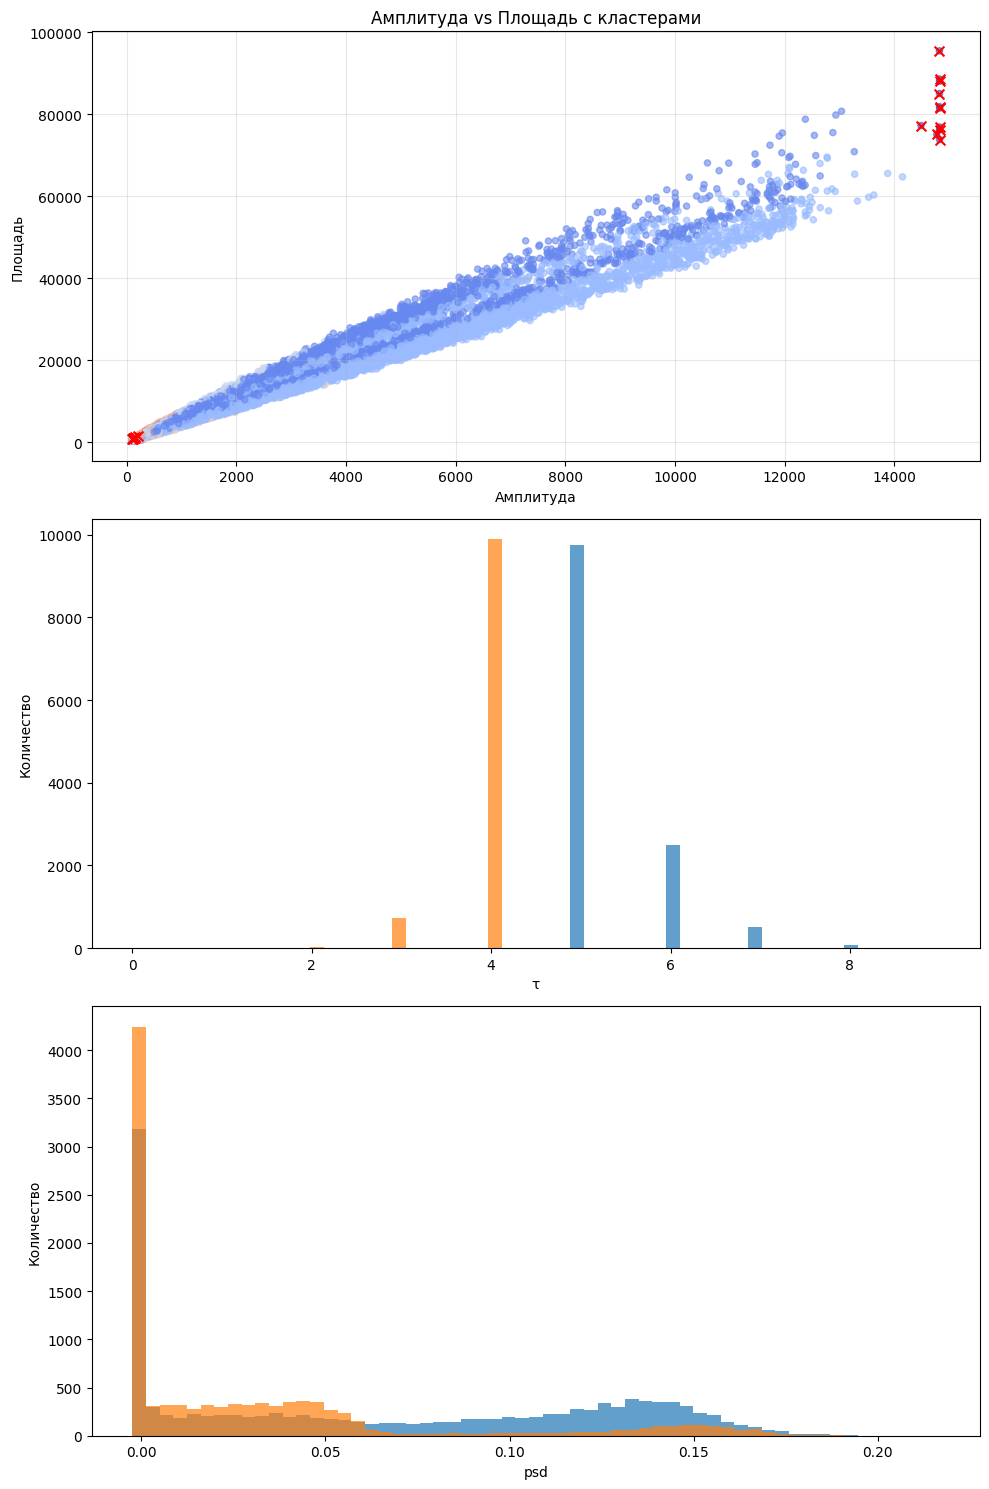

In [58]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

outliers_mask = labels == -1

scatter1 = axes[0].scatter(features_df['amplitude'], features_df['area'],
                           c=features_df['cluster_all'], cmap='coolwarm',
                           alpha=0.6, s=20)

axes[0].scatter(features_df.loc[outliers_mask, 'amplitude'],
                features_df.loc[outliers_mask, 'area'],
                c='red', marker='x', s=50, label='Outliers', zorder=10)
axes[0].set_xlabel('Амплитуда')
axes[0].set_ylabel('Площадь')
axes[0].set_title('Амплитуда vs Площадь с кластерами')
axes[0].grid(True, alpha=0.3)

tau_cluster0 = features_df[features_df['cluster'] == 0]['tau'].values
tau_cluster1 = features_df[features_df['cluster'] == 1]['tau'].values

bins = np.linspace(min(features_df['tau'].min(), 0),
                   features_df['tau'].max(), 60)

axes[1].hist(tau_cluster0, bins=bins, alpha=0.7, label='Кластер 0')
axes[1].hist(tau_cluster1, bins=bins, alpha=0.7, label='Кластер 1')

axes[1].set_xlabel('τ')
axes[1].set_ylabel('Количество')

psd_cluster0 = features_df[features_df['cluster'] == 0]['psd'].values
psd_cluster1 = features_df[features_df['cluster'] == 1]['psd'].values

bins = np.linspace(min(features_df['psd'].min(), 0),
                   features_df['psd'].max(), 60)

axes[2].hist(psd_cluster0, bins=bins, alpha=0.7, label='Кластер 0')
axes[2].hist(psd_cluster1, bins=bins, alpha=0.7, label='Кластер 1')

axes[2].set_xlabel('psd')
axes[2].set_ylabel('Количество')
plt.tight_layout()
plt.show()

In [44]:
submission = pd.DataFrame({
    'index': range(len(labels)),
    'cluster': labels
})

submission.to_csv('submission.csv', index=False)
print(submission.head())

   index  cluster
0      0        0
1      1        0
2      2        1
3      3        0
4      4        0
